In [1]:
# Hidden cell
import os, sys
import numpy as np
import pandas as pd
import xarray as xr
print("xarray: %s, %s" % (xr.__version__, xr.__file__))

import intake
import matplotlib.pyplot as plt
%matplotlib inline
sys.path.insert(0, os.path.abspath('/Users/gmaze/git/github/gmaze/pyxpcm'))

import pyxpcm
print("pyxpcm: %s, %s" % (pyxpcm.__version__, pyxpcm.__file__))

import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import seaborn as sns

xarray: 0.12.1, /Users/gmaze/anaconda/envs/obidam36/lib/python3.6/site-packages/xarray/__init__.py
pyxpcm: 0.4.0, /Users/gmaze/git/github/gmaze/pyxpcm/pyxpcm/__init__.py


## Create a model

First, let's import a Profile Classification Model (PCM) constructor:

In [2]:
from pyxpcm.pcmodel import pcm

In [3]:
# Define a vertical axis and features to use:
z = np.arange(0.,-1000,-10.)
pcm_features = {'temperature': z, 'salinity':z}

# Instantiate a PCM:
m = pcm(K=8, features=pcm_features)
m

<pcm 'gmm' (K: 8, F: 2)>
Number of class: 8
Number of feature: 2
Feature names: odict_keys(['temperature', 'salinity'])
Fitted: False
Feature: 'temperature'
	 Interpoler: <class 'pyxpcm.utils.Vertical_Interpolator'>
	 Scaler: 'normal', <class 'sklearn.preprocessing.data.StandardScaler'>
	 Reducer: True, <class 'sklearn.decomposition.pca.PCA'>
Feature: 'salinity'
	 Interpoler: <class 'pyxpcm.utils.Vertical_Interpolator'>
	 Scaler: 'normal', <class 'sklearn.preprocessing.data.StandardScaler'>
	 Reducer: True, <class 'sklearn.decomposition.pca.PCA'>
Classifier: 'gmm', <class 'sklearn.mixture.gaussian_mixture.GaussianMixture'>

In [4]:
ds = pyxpcm.tutorial.open_dataset('argo').load()
print(ds)

<xarray.Dataset>
Dimensions:    (DEPTH: 282, N_PROF: 7560)
Coordinates:
  * DEPTH      (DEPTH) float32 0.0 -5.0 -10.0 -15.0 ... -1395.0 -1400.0 -1405.0
Dimensions without coordinates: N_PROF
Data variables:
    LATITUDE   (N_PROF) float32 dask.array<shape=(7560,), chunksize=(7560,)>
    LONGITUDE  (N_PROF) float32 dask.array<shape=(7560,), chunksize=(7560,)>
    TIME       (N_PROF) datetime64[ns] dask.array<shape=(7560,), chunksize=(7560,)>
    DBINDEX    (N_PROF) float64 dask.array<shape=(7560,), chunksize=(7560,)>
    TEMP       (N_PROF, DEPTH) float32 dask.array<shape=(7560, 282), chunksize=(7560, 282)>
    PSAL       (N_PROF, DEPTH) float32 dask.array<shape=(7560, 282), chunksize=(7560, 282)>
    SIG0       (N_PROF, DEPTH) float32 dask.array<shape=(7560, 282), chunksize=(7560, 282)>
    BRV2       (N_PROF, DEPTH) float32 dask.array<shape=(7560, 282), chunksize=(7560, 282)>
Attributes:
    Sample test prepared by:  G. Maze
    Institution:              Ifremer/LOPS
    Data source D

## Fit model parameters

Fitting can be done on any dataset coherent with the PCM definition, in a sense that it should have the feature variables available. To tell the PCM model how to identify features in the dataset, we simply provide a direction mapping of variable names:

In [5]:
features_in_ds = {'temperature': 'TEMP', 'salinity': 'PSAL'}

which means that the PCM feature ``temperature`` is to be found in the dataset variables ``TEMP``. Now we can simply fit the model on the this dataset like:

In [6]:
# Fit:
ds.pyxpcm.fit(m, features=features_in_ds)
print(m,"\n")

<pcm 'gmm' (K: 8, F: 2)>
Number of class: 8
Number of feature: 2
Feature names: odict_keys(['temperature', 'salinity'])
Fitted: True
Feature: 'temperature'
	 Interpoler: <class 'pyxpcm.utils.Vertical_Interpolator'>
	 Scaler: 'normal', <class 'sklearn.preprocessing.data.StandardScaler'>
	 Reducer: True, <class 'sklearn.decomposition.pca.PCA'>
Feature: 'salinity'
	 Interpoler: <class 'pyxpcm.utils.Vertical_Interpolator'>
	 Scaler: 'normal', <class 'sklearn.preprocessing.data.StandardScaler'>
	 Reducer: True, <class 'sklearn.decomposition.pca.PCA'>
Classifier: 'gmm', <class 'sklearn.mixture.gaussian_mixture.GaussianMixture'>
	 log likelihood of the training set: 37.953144 



In [7]:
ds.pyxpcm.fit(m, features=features_in_ds, dim='DEPTH')

<pcm 'gmm' (K: 8, F: 2)>
Number of class: 8
Number of feature: 2
Feature names: odict_keys(['temperature', 'salinity'])
Fitted: True
Feature: 'temperature'
	 Interpoler: <class 'pyxpcm.utils.Vertical_Interpolator'>
	 Scaler: 'normal', <class 'sklearn.preprocessing.data.StandardScaler'>
	 Reducer: True, <class 'sklearn.decomposition.pca.PCA'>
Feature: 'salinity'
	 Interpoler: <class 'pyxpcm.utils.Vertical_Interpolator'>
	 Scaler: 'normal', <class 'sklearn.preprocessing.data.StandardScaler'>
	 Reducer: True, <class 'sklearn.decomposition.pca.PCA'>
Classifier: 'gmm', <class 'sklearn.mixture.gaussian_mixture.GaussianMixture'>
	 log likelihood of the training set: 38.005031

It is easy to determine whether the model is fitted or not with the PCM property ``fitted``:

In [8]:
print(m.fitted)

True


## Prediction of labels

Now that the PCM is fitted onto this dataset, we can predict the classification results like:

In [9]:
ds = ds.pyxpcm.predict(m, features=features_in_ds, inplace=True)
ds

<xarray.Dataset>
Dimensions:     (DEPTH: 282, N_PROF: 7560)
Coordinates:
  * N_PROF      (N_PROF) int64 0 1 2 3 4 5 6 ... 7554 7555 7556 7557 7558 7559
  * DEPTH       (DEPTH) float32 0.0 -5.0 -10.0 -15.0 ... -1395.0 -1400.0 -1405.0
Data variables:
    LATITUDE    (N_PROF) float32 dask.array<shape=(7560,), chunksize=(7560,)>
    LONGITUDE   (N_PROF) float32 dask.array<shape=(7560,), chunksize=(7560,)>
    TIME        (N_PROF) datetime64[ns] dask.array<shape=(7560,), chunksize=(7560,)>
    DBINDEX     (N_PROF) float64 dask.array<shape=(7560,), chunksize=(7560,)>
    TEMP        (N_PROF, DEPTH) float32 dask.array<shape=(7560, 282), chunksize=(7560, 282)>
    PSAL        (N_PROF, DEPTH) float32 dask.array<shape=(7560, 282), chunksize=(7560, 282)>
    SIG0        (N_PROF, DEPTH) float32 dask.array<shape=(7560, 282), chunksize=(7560, 282)>
    BRV2        (N_PROF, DEPTH) float32 dask.array<shape=(7560, 282), chunksize=(7560, 282)>
    PCM_LABELS  (N_PROF) int64 7 7 7 7 7 7 7 7 7 7 7 7 ... 5

Prediction labels are automatically added to the dataset as ``PCM_LABELS`` (because the option ``inplace`` was set to ``True``. 

Since we used a GMM classifier by default, we also can predict the probability of each classes for all profiles, the so-called *posteriors*:

In [10]:
ds = ds.pyxpcm.predict_proba(m, features=features_in_ds, inplace=True)

which are added to the dataset as the ``PCM_POST`` variables.

Note that you can delete pyXpcm variables from your dataset with the :func:`pyxpcm.pcm.clean()` method:

In [11]:
print('Before:', ds.data_vars)
ds_before = ds.pyxpcm.clean()
print('After cleaning:', ds_before.data_vars)

Before: Data variables:
    LATITUDE    (N_PROF) float32 dask.array<shape=(7560,), chunksize=(7560,)>
    LONGITUDE   (N_PROF) float32 dask.array<shape=(7560,), chunksize=(7560,)>
    TIME        (N_PROF) datetime64[ns] dask.array<shape=(7560,), chunksize=(7560,)>
    DBINDEX     (N_PROF) float64 dask.array<shape=(7560,), chunksize=(7560,)>
    TEMP        (N_PROF, DEPTH) float32 dask.array<shape=(7560, 282), chunksize=(7560, 282)>
    PSAL        (N_PROF, DEPTH) float32 dask.array<shape=(7560, 282), chunksize=(7560, 282)>
    SIG0        (N_PROF, DEPTH) float32 dask.array<shape=(7560, 282), chunksize=(7560, 282)>
    BRV2        (N_PROF, DEPTH) float32 dask.array<shape=(7560, 282), chunksize=(7560, 282)>
    PCM_LABELS  (N_PROF) int64 7 7 7 7 7 7 7 7 7 7 7 7 ... 5 5 5 5 5 5 5 5 5 5 5
    PCM_POST    (pcm_class, N_PROF) float64 2.923e-13 2.4e-14 ... 0.0 0.0
After cleaning: Data variables:
    LATITUDE   (N_PROF) float32 dask.array<shape=(7560,), chunksize=(7560,)>
    LONGITUDE  (N_PRO

## Example of visualisation

To follow this section you’ll need to have Cartopy installed and working.  
A map of labels can now easily be plotted:

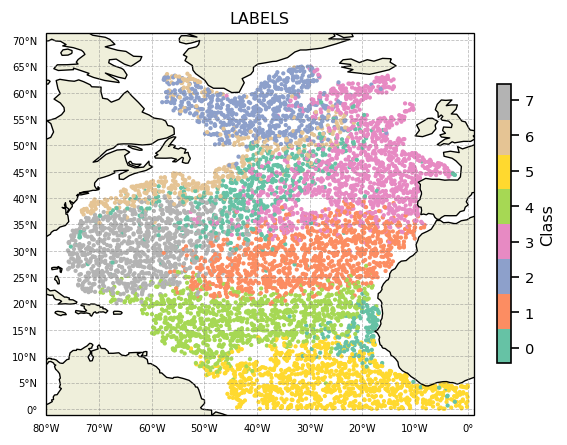

In [12]:
proj = ccrs.PlateCarree()
subplot_kw={'projection': proj, 'extent': np.array([-80,1,-1,66]) + np.array([-0.1,+0.1,-0.1,+0.1])}
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5), dpi=120, facecolor='w', edgecolor='k', subplot_kw=subplot_kw)

cmap = m.plot.cmap()
sc = ax.scatter(ds['LONGITUDE'], ds['LATITUDE'], s=3, c=ds['PCM_LABELS'], cmap=cmap, transform=proj, vmin=0, vmax=m.K)
cl = m.plot.colorbar(ax=ax)

gl = m.plot.latlongrid(ax, dx=10)
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
ax.set_title('LABELS')
plt.show()

*Posteriors* are defined for each data point and give the probability of that point to belong to any of the classes. It can be plotted this way:

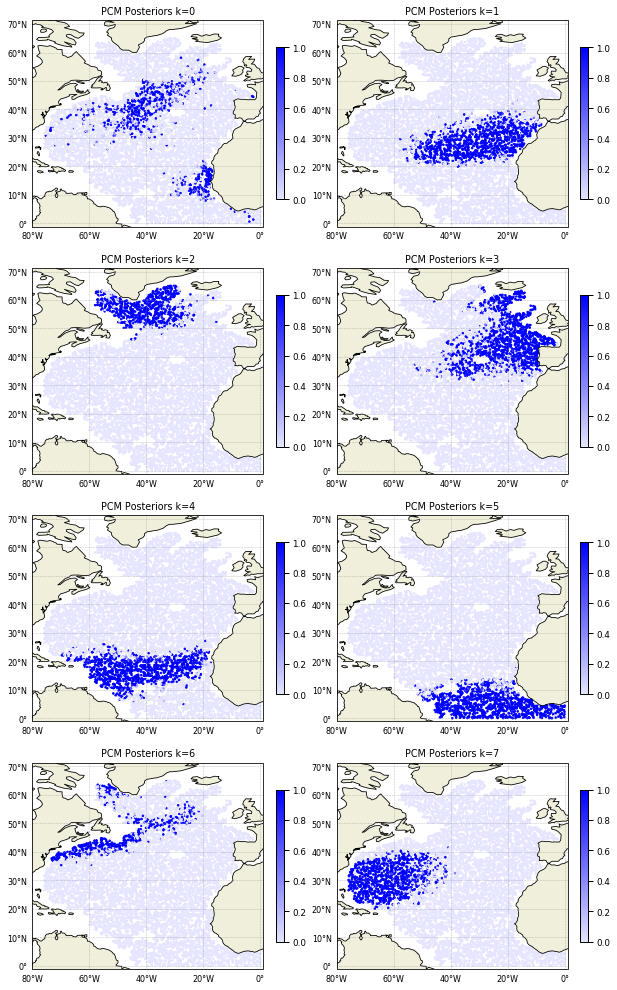

In [13]:
cmap = sns.light_palette("blue", as_cmap=True)
proj = ccrs.PlateCarree()
subplot_kw={'projection': proj, 'extent': np.array([-80,1,-1,66]) + np.array([-0.1,+0.1,-0.1,+0.1])}
fig, ax = m.plot.subplots(figsize=(10,22), maxcols=2, subplot_kw=subplot_kw)

for k in m:
    sc = ax[k].scatter(ds['LONGITUDE'], ds['LATITUDE'], s=3, c=ds['PCM_POST'].sel(pcm_class=k), 
                       cmap=cmap, transform=proj, vmin=0, vmax=1)
    cl = plt.colorbar(sc, ax=ax[k], fraction=0.03)
    gl = m.plot.latlongrid(ax[k], fontsize=8, dx=20, dy=10)
    ax[k].add_feature(cfeature.LAND)
    ax[k].add_feature(cfeature.COASTLINE)
    ax[k].set_title('PCM Posteriors k=%i' % k)

In [14]:
ds = ds.compute() # This is necessary if data are in dask arrays
for vname in ['TEMP', 'PSAL']:
    ds = ds.pyxpcm.quantile([0.05, 0.5, 0.95], of=vname, outname=vname + '_Q', keep_attrs=True, inplace=True)
print(ds)

<xarray.Dataset>
Dimensions:     (DEPTH: 282, N_PROF: 7560, pcm_class: 8, quantile: 3)
Coordinates:
  * pcm_class   (pcm_class) int64 0 1 2 3 4 5 6 7
  * N_PROF      (N_PROF) int64 0 1 2 3 4 5 6 ... 7554 7555 7556 7557 7558 7559
  * DEPTH       (DEPTH) float32 0.0 -5.0 -10.0 -15.0 ... -1395.0 -1400.0 -1405.0
  * quantile    (quantile) float64 0.05 0.5 0.95
Data variables:
    LATITUDE    (N_PROF) float32 27.122 27.818 27.452 26.976 ... 4.243 4.15 4.44
    LONGITUDE   (N_PROF) float32 -74.86 -75.6 -74.949 ... -1.263 -0.821 -0.002
    TIME        (N_PROF) datetime64[ns] 2008-06-23T13:07:30 ... 2013-03-09T14:52:58.124999936
    DBINDEX     (N_PROF) float64 1.484e+04 1.622e+04 ... 8.557e+03 1.063e+04
    TEMP        (N_PROF, DEPTH) float32 27.422163 27.422163 ... 4.391791
    PSAL        (N_PROF, DEPTH) float32 36.35267 36.35267 ... 34.910286
    SIG0        (N_PROF, DEPTH) float32 23.601229 23.601229 ... 27.685583
    BRV2        (N_PROF, DEPTH) float32 0.00029447526 ... 4.500769e-06
    

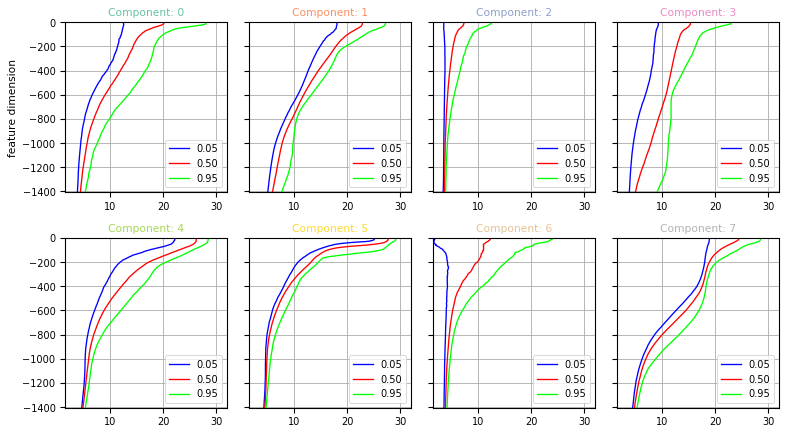

In [15]:
fig, ax = m.plot.quantile(ds['TEMP_Q'], maxcols=4, figsize=(10, 8), sharey=True)

## More metrics

In [16]:
# Compute robustness of the classification:
ds = ds.pyxpcm.robustness(inplace=True)
ds = ds.pyxpcm.robustness_digit(inplace=True)

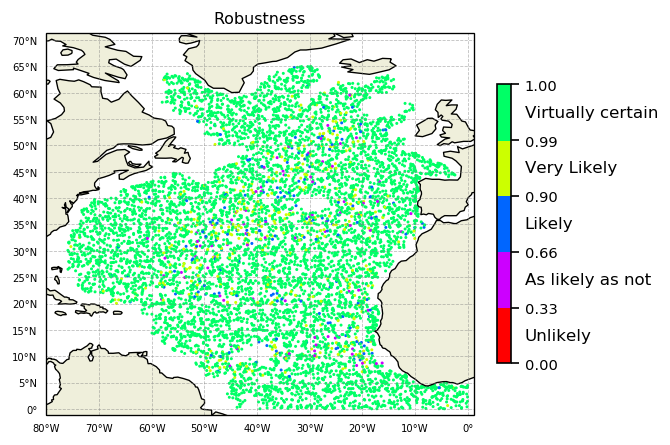

In [17]:
proj = ccrs.PlateCarree()
subplot_kw={'projection': proj, 'extent': np.array([-80,1,-1,66]) + np.array([-0.1,+0.1,-0.1,+0.1])}
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5), dpi=120, facecolor='w', edgecolor='k', subplot_kw=subplot_kw)

cmap = m.plot.cmap(usage='robustness')
boundaries = ds['PCM_ROBUSTNESS_CAT'].attrs['bins']
rowl0 = ds['PCM_ROBUSTNESS_CAT'].attrs['legend']
norm = mpl.colors.BoundaryNorm(boundaries, cmap.N, clip=True)
sc = ax.scatter(ds['LONGITUDE'], ds['LATITUDE'], s=1, c=ds['PCM_ROBUSTNESS'], cmap=cmap, norm=norm, transform=proj)
cl = plt.colorbar(sc,ax=ax, fraction=0.03)
for (i,j) in zip(np.arange(0.1,1,1/5), rowl0):
    cl.ax.text(2, i, j, ha='left', va='center')

gl = m.plot.latlongrid(ax, dx=10)
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
ax.set_title('Robustness')
plt.show()